In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.metrics import recall_score, precision_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, cross_validate

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

import mlflow
from mlflow.sklearn import autolog as autolog_sk

In [40]:
data = pd.read_csv('jena_climate_2009_2016.csv')
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Check the data types to see if we need to change any. Turns out all the columns except date_time are appropriately typed.

In [41]:
data.dtypes

Date Time           object
p (mbar)           float64
T (degC)           float64
Tpot (K)           float64
Tdew (degC)        float64
rh (%)             float64
VPmax (mbar)       float64
VPact (mbar)       float64
VPdef (mbar)       float64
sh (g/kg)          float64
H2OC (mmol/mol)    float64
rho (g/m**3)       float64
wv (m/s)           float64
max. wv (m/s)      float64
wd (deg)           float64
dtype: object

A look at the definitions of the various columns on the [Kaggle page](https://www.kaggle.com/datasets/mnassrib/jena-climate) tells us that 
1. TPot is simply T in degrees Kelvin, so we can drop it and
2. VPdef is the vapour pressure deficit, which is simply the difference between VPMax (max vapour pressure) and VPact (actual vapour pressure). Therefore there's no need to have that as a feature. (it could make an interesting target, though.)

In [42]:
data = data.drop('Tpot (K)', axis=1)

Rename the columns with more readable titles

In [43]:
data.columns


Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [44]:
renamer = {
    'Date Time': "date_time",
    'p (mbar)': "pressure", # air pressure in millibars
    'T (degC)': "temp", # air temperature in degrees Celsius
    'Tdew (degC)': "dew_temp", # dew temperature in degrees Celsius
    'rh (%)': "rel_hum", # relative humidity
    'VPmax (mbar)': "max_vap_press", # saturation vapour pressure in millibars
    'VPact (mbar)': "actual_vap_press", # actual vapour pressure in millibars
    'VPdef (mbar)': "vap_press_deficit", # vapour pressure deficit in millibars
    'sh (g/kg)': "spec_hum", # specific humidity g of water in kg of air
    'H2OC (mmol/mol)': "wv_conc", # water vapour concentration millimoles of water/mole of air
    'rho (g/m**3)': "air_density", # density of air
    'wv (m/s)': "wind_speed",
    'max. wv (m/s)': "max_wind_speed",
    'wd (deg)': "wind_direction"
}

new_columns = [renamer[column] for column in data.columns]

Check if new names are aligned properly with old ones

In [45]:
for i, column in enumerate(data.columns):
    print(f'{column}:   {new_columns[i]}')

Date Time:   date_time
p (mbar):   pressure
T (degC):   temp
Tdew (degC):   dew_temp
rh (%):   rel_hum
VPmax (mbar):   max_vap_press
VPact (mbar):   actual_vap_press
VPdef (mbar):   vap_press_deficit
sh (g/kg):   spec_hum
H2OC (mmol/mol):   wv_conc
rho (g/m**3):   air_density
wv (m/s):   wind_speed
max. wv (m/s):   max_wind_speed
wd (deg):   wind_direction


In [46]:
data.columns = new_columns
data.head()

,date_time,pressure,temp,dew_temp,rel_hum,max_vap_press,actual_vap_press,vap_press_deficit,spec_hum,wv_conc,air_density,wind_speed,max_wind_speed,wind_direction
0,01.01.2009 00:10:00,996.52,-8.02,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


We check for missing values and find that there are none. 

In [47]:
data.isnull().sum()


date_time            0
pressure             0
temp                 0
dew_temp             0
rel_hum              0
max_vap_press        0
actual_vap_press     0
vap_press_deficit    0
spec_hum             0
wv_conc              0
air_density          0
wind_speed           0
max_wind_speed       0
wind_direction       0
dtype: int64

Convert date_time to type datetime and extract values for various timescales

In [48]:
data['date_time'] = pd.to_datetime(data['date_time'], format='%d.%m.%Y %H:%M:%S')

data['year'] = [value.year for value in data['date_time']]
data['month'] = [value.month for value in data['date_time']]
data['day'] = [value.day for value in data['date_time']]
data['hour'] = [value.hour for value in data['date_time']]
data['minute'] = [value.minute for value in data['date_time']]


In [49]:
def circularise(series):
    # shrink to 0 to 2*pi
    min = np.min(series)
    max = np.max(series)
    series = series - min
    series = series*2*np.pi/max

    sine = np.sin(series)
    cosine = np.cos(series)

    return (sine, cosine)




# create modellable feature list and add sine and cosine features


In [50]:
circular_features = ['month', 'day', 'hour', 'minute', 'wind_direction']

for feature in circular_features:
    sine, cosine = circularise(data[feature])
    data[f'{feature}_sine'] = sine
    data[f'{feature}_sine_slant'] = np.sign(cosine)


In [51]:
data.columns


Index(['date_time', 'pressure', 'temp', 'dew_temp', 'rel_hum', 'max_vap_press',
       'actual_vap_press', 'vap_press_deficit', 'spec_hum', 'wv_conc',
       'air_density', 'wind_speed', 'max_wind_speed', 'wind_direction', 'year',
       'month', 'day', 'hour', 'minute', 'month_sine', 'month_sine_slant',
       'day_sine', 'day_sine_slant', 'hour_sine', 'hour_sine_slant',
       'minute_sine', 'minute_sine_slant', 'wind_direction_sine',
       'wind_direction_sine_slant'],
      dtype='object')

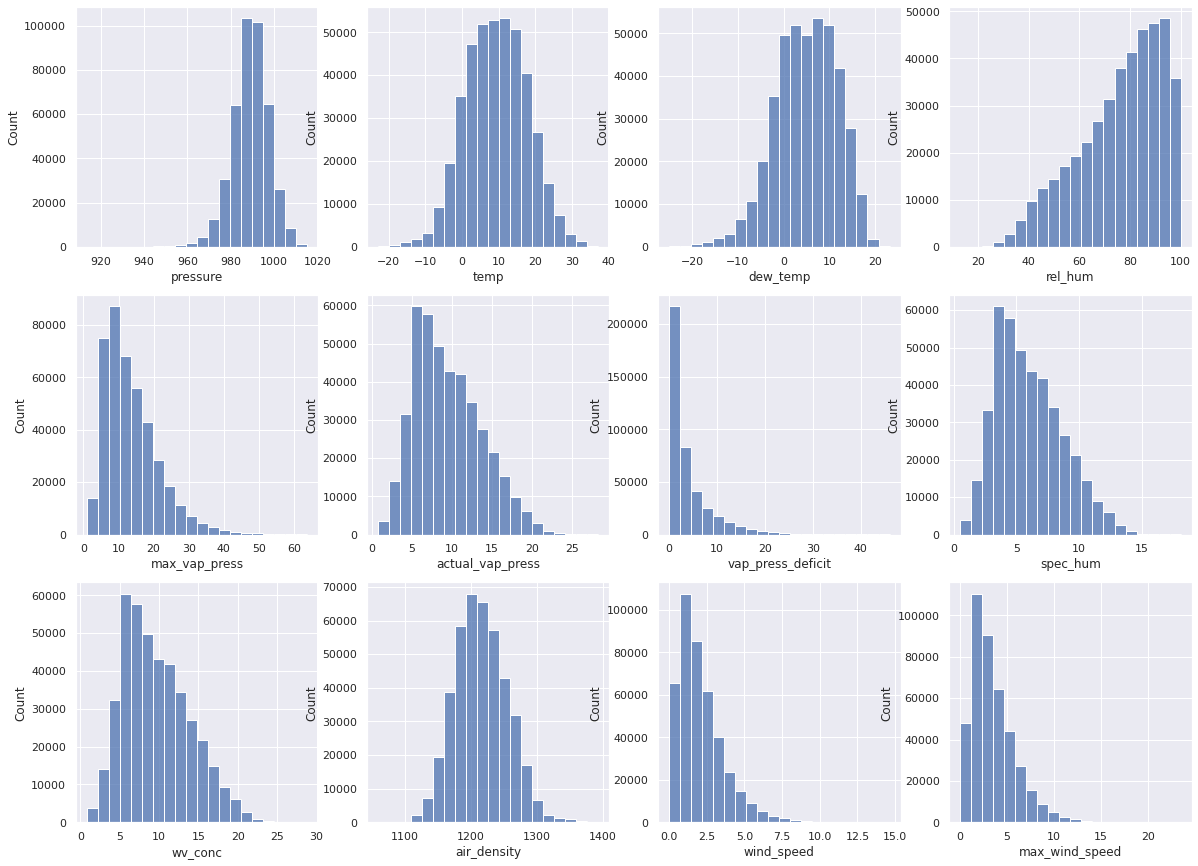

In [52]:
sns.set_theme()
nrows = 3
ncols = 4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(20,15)
features = ['pressure', 'temp', 'dew_temp', 'rel_hum', 'max_vap_press',\
       'actual_vap_press', 'vap_press_deficit', 'spec_hum', 'wv_conc',\
       'air_density', 'wind_speed', 'max_wind_speed']
features.reverse()

for row in range(nrows):
    for col in range(ncols):
        feature = features.pop()
        sns.histplot(data[feature], bins=20, ax=axs[row,col])


As an interesting aside, here's a chart that demonstrates that [temperature can never fall below dew point](https://socratic.org/questions/what-happens-when-the-temperature-goes-below-the-dew-point). 

<AxesSubplot:xlabel='temp', ylabel='dew_temp'>

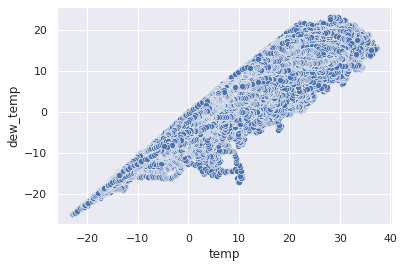

In [53]:
sns.scatterplot(x=data['temp'], y=data['dew_temp'])

Create the Boolean target feature data['precipitates'] using as a proxy the boolean of temperature was within 0.1% of the dew temperature (both in degrees K)). Then compute the percentage of observations at which precipitation occured. 

In [54]:

data['precipitates'] = np.abs((data['temp']-data['dew_temp']) / (273+data['dew_temp']) )< 0.001
data['precipitates'].sum()/data.shape[0]*100


# perc_diff = 100*np.abs((data['temp']-data['dew_temp'])/(273+data['dew_temp']))

3.3613905068604906

We notice that this is a fairly unbalanced dataset with only 3.4% of the observations being True.
However, there is likely to be a high serial correlation. 


In [55]:
data['month']

0          1
1          1
2          1
3          1
4          1
          ..
420446    12
420447    12
420448    12
420449    12
420450     1
Name: month, Length: 420451, dtype: int64

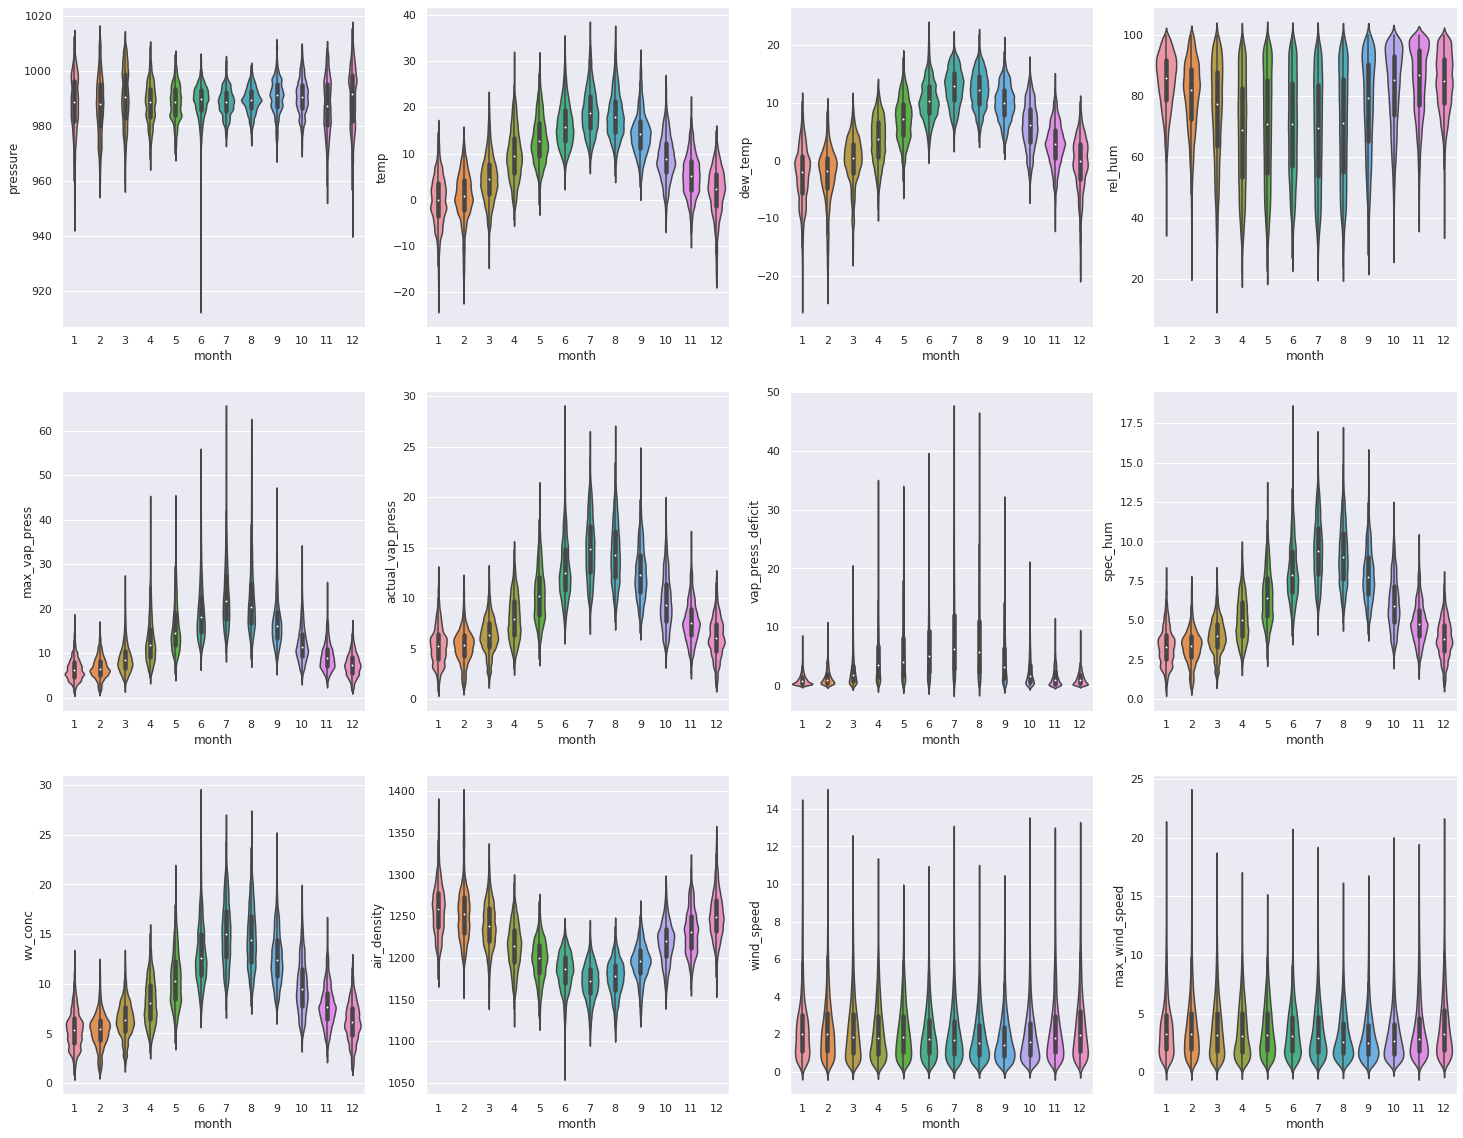

In [56]:

nrows = 3
ncols = 4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(25,20)
features = ['pressure', 'temp', 'dew_temp', 'rel_hum', 'max_vap_press',\
       'actual_vap_press', 'vap_press_deficit', 'spec_hum', 'wv_conc',\
       'air_density', 'wind_speed', 'max_wind_speed']
features.reverse()

for row in range(nrows):
    for col in range(ncols):
        feature = features.pop()
        sns.violinplot(x=data['month'], y=data[feature],ax=axs[row,col])


Some observations from the above violin plots:
- as expected, temperature is low during winter months and high during summer months, but the range of 30-35 degrees for almost every month is very surprising.
- average pressure and windspeeds are fairly steady across the year, though the variance in pressure is markedly higher in the winter.


Next, we take a look at the conditional probability of the target variable being 'True' a certain time after the latest observation given that the current observation is 'True'. Similarly, we ask, what is the probability that the target variable will be false 

So, now we have baselines by which to evaluate our models. The chance that the target is True 10 minutes from the latest observation is 95%. Because of this high serial correlation, there's no point making a model to forecast it. Similarly for the one hour forecast.  
So, we'll restrict ourselves to modelling values for 6 hours, 12 hours, and 24 hours. And, as the numbers suggest, our model needs to have recalls of better than 41%, 24%, and 28% respectively.  
Of course, we use recall instead of accuracy because this is a very unbalanced dataset and our objective is to have a model that makes predictions of True when it's likely to rain instead of give us lots of false positives. 

In [59]:
len(data.columns)

30

In [64]:
features = ['pressure', 'temp', 'dew_temp', 'rel_hum', 'max_vap_press', 'month', 'day', 'hour', 'minute', 'month_sine', 'month_sine_slant',\
            'day_sine', 'day_sine_slant', 'hour_sine', 'hour_sine_slant', 'minute_sine', 'minute_sine_slant', 'wind_direction_sine',\
            'wind_direction_sine_slant', 'precipitates'] 
# features = ['pressure', 'temp', 'dew_temp', 'rel_hum', 'max_vap_press',\
#             'actual_vap_press', 'spec_hum', 'wv_conc','air_density',\
#             'wind_speed', 'max_wind_speed', 'wind_direction', 'month_sine',\
#             'month_sine_slant', 'day_sine', 'day_sine_slant', 'hour_sine',\
#             'hour_sine_slant', 'minute_sine', 'minute_sine_slant',\
#             'wind_direction_sine','wind_direction_sine_slant']
# target = 'precipitates'
target = 'temp'

metric = mean_absolute_error
metric_name = "MAE"

ticks_dict = {1:'10 min', 6:'1 hr', 36:'6 hrs',72:'12 hrs',108:'18 hrs',144:'24 hrs'} #10 minutes, 1hr, 6hrs, 12hrs

# Establish a baseline performance for predictions as the value 24 hours before the time being predicted.

print(f"Time\tTicks\t{metric_name}")#\tFalse Percentage")
for ticks in ticks_dict:
    y_pred = data[target][ticks:-144]
    y_true = data[target][144+ticks:]

    performance = metric(y_true, y_pred)
    print(f"{ticks_dict[ticks]}\t{ticks}\t{performance:.5f}")   

# assess the variance of the error

Time	Ticks	MAE
10 min	1	2.61322
1 hr	6	2.61321
6 hrs	36	2.61307
12 hrs	72	2.61296
18 hrs	108	2.61293
24 hrs	144	2.61306


Next, create an X and y for the ML models based on the chosen target. Having done that, we also standardise the np array X and split out the train and test sets. 

In [65]:
X = data[features]
y = data[target]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

train_data_length = 300000
ticks = 72

X_train = X[:train_data_length-ticks]
y_train = y[ticks:train_data_length]

X_test = X[train_data_length-ticks:-ticks]
y_test = y[train_data_length:]

print(X_train.shape[0], len(y_train))
print(X_test.shape[0], len(y_test))

299928 299928
120451 120451


Finally, we create a classifier/regressor, train it, and assess it. 

In [66]:
# mlflow.autolog()

# clf = DecisionTreeClassifier(max_depth=2)

# clf = RandomForestClassifier(max_depth=5)
# clf = GradientBoostingClassifier()
# clf = LogisticRegression()

# clf = LogisticRegression()#penalty='l1', solver='liblinear')
# clf = LogisticRegression(penalty='l2', solver='liblinear')

clf = LinearRegression()
# clf = RandomForestRegressor()
# clf = Ridge()
# clf = Lasso()
# clf = DecisionTreeRegressor()
# clf = AdaBoostRegressor()
# clf.fit(X_train,y_train)


# rf_param_grid = {
#     'n_estimators': [100, 500],
#     'max_features': ['sqrt', 'log2'],
#     'max_depth': [3,5,7]
# }

# CV_clf = cross_validate(X_train, y_train, scoring='neg_mean_absolute_error')
# CV_clf = GridSearchCV(estimator=clf, param_grid=rf_param_grid, scoring='neg_mean_absolute_error', n_jobs=10, verbose=4)

# CV_clf.fit(X_train, y_train)

clf.fit(X_train,y_train)

# clf = CV_clf.best_estimator_
y_true = y_test
y_pred = clf.predict(X_test)
# y_pred = X_test['precipitates']
# recall = recall_score(y_test, y_pred)

print(metric(y_true, y_pred))

2022/04/24 10:59:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ab5e42f7644e4e959364d7a659e71a78', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/04/24 10:59:59 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp4qzwelm5/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


2.562912082127635


In [38]:
print(metric(y_train, clf.predict(X_train)))


2.324748928072396


In [31]:
mlflow.autolog()
r = LinearRegression()
# r.fit(X_train, y_train)
scores = cross_validate(r, X_train, y_train, cv=5)
# predictions = r.predict(X_test)
# autolog_run = mlflow.last_active_run()

2022/04/18 19:53:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2022/04/18 19:53:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2022/04/18 19:53:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2022/04/18 19:53:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7876a4b75f1f4de7975d4c76048bfe7f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/04/18 19:53:27 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp6ijyuhrd/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.
2022/04/18 19:53:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'de66a95e3a49418192a5d88aa1f5203d', which will 

In [22]:
# with mlflow.start_run():
#     r = LinearRegression()
#     r.fit(X_train, y_train)

#     mlflow.log_metric('MAE', mean_absolute_error(y_test, r.predict(X_test)))

In [66]:
input_size = X.shape[1]
model = tf.keras.Sequential([
    layers.Dense(2*input_size, activation='relu', input_shape=(input_size,)),
    layers.Dense(20, activation='relu'),
    layers.Dense(1)
])

model.compile(loss=tf.keras.losses.MeanAbsoluteError())#, metrics=[tf.keras.metrics.Recall()])

model.fit(X_train, y_train, epochs=10)#, validation_split=0.2)

y_pred = model.predict(X_test)
y_true = y_test
print(metric(y_true, y_pred))
    

Epoch 1/10
9373/9373 [==============================] - 6s 628us/step - loss: 2.3590
Epoch 2/10
9373/9373 [==============================] - 6s 646us/step - loss: 2.0261
Epoch 3/10
9373/9373 [==============================] - 7s 696us/step - loss: 1.9619
Epoch 4/10
9373/9373 [==============================] - 6s 633us/step - loss: 1.9323
Epoch 5/10
9373/9373 [==============================] - 6s 621us/step - loss: 1.9126
Epoch 6/10
9373/9373 [==============================] - 6s 630us/step - loss: 1.8994
Epoch 7/10
9373/9373 [==============================] - 6s 615us/step - loss: 1.8912
Epoch 8/10
9373/9373 [==============================] - 6s 633us/step - loss: 1.8828
Epoch 9/10
9373/9373 [==============================] - 6s 616us/step - loss: 1.8747
Epoch 10/10
9373/9373 [==============================] - 6s 622us/step - loss: 1.8691
2.075577233125014


In [50]:
# print(metric(y_test, y_pred.reshape(y_test.shape)))


# X_test.shape
# y_test.shape
# y_pred.shape


2.122311252056461


In [53]:
y_true.shape

(420163,)

EDA
- line charts over years for different times of the day
- monthwise average number of trues
- temps in different months for different times of the day
- distribution of wind direction
- check for serial correlation of variables and target and shrink dataset if necessary

FE
- Split date time
    - year index (?)
    - month
    - week of month
    (don't use week of year as that will need 53 columns. splitting it out into month and week of month needs just 16 columns)
    - am/pm (?)
    - hours as categories?
    - year
    - convert months, hours, and minutes to circular ordinal (from ints)
- anomalies
- drop vapour pressure deficit?
- featurise direction (ordinal, circular) https://www.isical.ac.in/~asu/TR/TechRepASU201701.pdf 






In [ ]:
# Make dictionary for months (is it needed if I'm going to make months circular ordinal?)
# months_list = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
# months_dict = {i:months_list[i-1] for i in range(1,13)}